In [18]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

from sklearn.preprocessing import MinMaxScaler

In [19]:
file_gas = Path("Gasoline80_22.csv")
file_cpi = Path("CPI_Average.csv")

In [20]:
gasoline_file = pd.read_csv(file_gas)
CPI_file = pd.read_csv(file_cpi)

In [21]:
df_gas = pd.DataFrame(gasoline_file)
df_gas.set_index(pd.to_datetime(df_gas['Year'], infer_datetime_format=True), inplace=True)
df_gas = df_gas.drop(columns=['Year'], axis=1)
df_gas = df_gas.pct_change()


df_cpi = pd.DataFrame(CPI_file)
df_cpi.set_index(pd.to_datetime(df_cpi['Year'], infer_datetime_format=True), inplace=True) 
df_cpi = df_cpi.drop(columns=['Year'], axis=1)
df_cpi  = df_cpi.pct_change()

In [22]:
df_inflation = pd.concat([df_gas,df_cpi], axis="columns", join = "inner")

In [23]:
df_inflation.head()

,Gasoline,CPI
Year,,
1980-01-01,NaN,NaN
1980-02-01,0.069005,0.014139
1980-03-01,0.037037,0.015209
1980-04-01,0.010204,0.011236
1980-05-01,0.002020,0.009877


In [24]:
def fill_missing(values):
    one_month = 30
    for row in range(df_inflation.shape[0]):
        for col in range(df_inflation.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_month,col]
df_inflation = df_inflation.astype('float32')
fill_missing(df_inflation.values)
df_inflation.isnull().sum()

Gasoline    0
CPI         0
dtype: int64

In [25]:
def window_data(df_inflation, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df_inflation) - window):
        features = df_inflation.iloc[i : (i + window), feature_col_number]
        target = df_inflation.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [26]:
 # Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 1
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df_inflation, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:10]} \n")
print (f"y sample values:\n{y[:10]}")


X sample values:
[[-0.00090977  0.01413882  0.01520913  0.01123596  0.00987654  0.01100244
   0.          0.00725514  0.00840336  0.00952381  0.00825472  0.00935673
   0.00811124  0.01034483  0.00682594  0.00677966  0.00785634  0.00890869
   0.01103753  0.00764192  0.00975081  0.00214592  0.00321199  0.00320171
   0.00319149  0.00318134 -0.00105708  0.0042328   0.00948367  0.0125261 ]
 [ 0.01413882  0.01520913  0.01123596  0.00987654  0.01100244  0.
   0.00725514  0.00840336  0.00952381  0.00825472  0.00935673  0.00811124
   0.01034483  0.00682594  0.00677966  0.00785634  0.00890869  0.01103753
   0.00764192  0.00975081  0.00214592  0.00321199  0.00320171  0.00319149
   0.00318134 -0.00105708  0.0042328   0.00948367  0.0125261   0.00515464]
 [ 0.01520913  0.01123596  0.00987654  0.01100244  0.          0.00725514
   0.00840336  0.00952381  0.00825472  0.00935673  0.00811124  0.01034483
   0.00682594  0.00677966  0.00785634  0.00890869  0.01103753  0.00764192
   0.00975081  0.00214592  

In [27]:
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [29]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.3064533 ]
  [0.9539479 ]
  [1.        ]
  [0.93724465]
  [0.8711197 ]
  [0.92588615]
  [0.3907015 ]
  [0.7436084 ]
  [0.79946065]
  [0.8539619 ]
  [0.79223025]
  [0.8599324 ]
  [0.8606378 ]
  [0.9311447 ]
  [0.8200651 ]
  [0.81860423]
  [0.85259145]
  [0.8858105 ]
  [0.9530109 ]
  [0.84582293]
  [0.91239357]
  [0.6723326 ]
  [0.70598483]
  [0.7056602 ]
  [0.70533764]
  [0.70501715]
  [0.5712244 ]
  [0.7382085 ]
  [0.9039607 ]
  [1.        ]]

 [[0.9539479 ]
  [1.        ]
  [0.82904667]
  [0.8711197 ]
  [0.92588615]
  [0.3907015 ]
  [0.7436084 ]
  [0.79946065]
  [0.8539619 ]
  [0.79223025]
  [0.8458345 ]
  [0.8048892 ]
  [0.9311447 ]
  [0.8200651 ]
  [0.81860423]
  [0.85259145]
  [0.8858105 ]
  [0.9530109 ]
  [0.84582293]
  [0.91239357]
  [0.6723326 ]
  [0.70598483]
  [0.7056602 ]
  [0.70533764]
  [0.70501715]
  [0.5712244 ]
  [0.7382085 ]
  [0.9039607 ]
  [1.        ]
  [0.76730776]]

 [[1.        ]
  [0.82904667]
  [0.7705554 ]
  [0.92588615]
  [0.3907015 

In [30]:
model = Sequential()

# Initial model setup
number_units = 400
#hidden_units = 17 
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))


# Output layer
model.add(Dense(1))

In [31]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 400)           643200    
                                                                 
 dropout_4 (Dropout)         (None, 30, 400)           0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 400)           1281600   
                                                                 
 dropout_5 (Dropout)         (None, 30, 400)           0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 400)           1281600   
                                                                 
 dropout_6 (Dropout)         (None, 30, 400)           0         
                                                                 
 lstm_7 (LSTM)               (None, 400)              

In [33]:
model.fit(X_train, y_train, epochs=500, shuffle=False, batch_size=100, verbose=1)

Epoch 1/500
4/4 [==============================] - 4s 26ms/step - loss: 3.5384
Epoch 2/500
4/4 [==============================] - 0s 25ms/step - loss: 0.4182
Epoch 3/500
4/4 [==============================] - 0s 24ms/step - loss: 0.3363
Epoch 4/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0956
Epoch 5/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0612
Epoch 6/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0669
Epoch 7/500
4/4 [==============================] - 0s 25ms/step - loss: 0.0297
Epoch 8/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0297
Epoch 9/500
4/4 [==============================] - 0s 26ms/step - loss: 0.0127
Epoch 10/500
4/4 [==============================] - 0s 27ms/step - loss: 0.0219
Epoch 11/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0128
Epoch 12/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0149
Epoch 13/500
4/4 [==============================]

In [34]:
model.evaluate(X_test, y_test, verbose=0)

0.01757320575416088

In [35]:
predicted = model.predict(X_test)

5/5 [==============================] - 1s 10ms/step


In [36]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [37]:
# Create a DataFrame of Real and Predicted values
CPI = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df_inflation.index[-len(real_prices): ]) 

# Show the DataFrame's head
CPI.tail()

,Actual,Predicted
Year,,
2022-01-01,0.008415,0.001742
2022-02-01,0.009134,0.001857
2022-03-01,0.013351,0.002056
2022-04-01,0.005583,0.002015
2022-05-01,0.011024,0.002209


<AxesSubplot:title={'center':'Actual Vs. Predicted'}, xlabel='Year'>

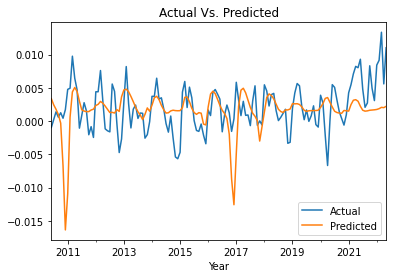

In [38]:
CPI.plot(title="Actual Vs. Predicted")

In [39]:
CPI.to_csv('gas_predict.csv')